In [1]:
import datetime as dt  
import pandas as pd
import numpy as np
from netCDF4 import Dataset 
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Path, PathPatch # for making ocean white
import cartopy.crs as ccrs
from ncdump import ncdump
import gdal
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # colormap inside figure
import matplotlib.ticker as mticker # xticks in gridlines
import matplotlib.colors as mcolors
from VPRM_params import NLCD_def, bbox
from VPRMout_fun import Read_VPRMout,latlon_to_EPSG32618,find_a_point_in_grids,get_first_dimension_ave

FigDir = '/home/dwei/manuscripts/VPRM-sensitivity/fig/'
VPRMoutDir = '/data0/dwei/VPRMout/'

# Load NLCD and ISA
DataDir = '/data0/dwei/VPRMdata/'  # input dir
ds_nlcd = gdal.Open(DataDir+'nlcd_epsg32618_cropped.tif')
ds_ipsa = gdal.Open(DataDir+'ipsa_epsg32618_cropped.tif')
NLCD_2D = ds_nlcd.GetRasterBand(1).ReadAsArray()
IPSA_2D = ds_ipsa.GetRasterBand(1).ReadAsArray()
NLCD    = NLCD_2D.reshape(np.size(NLCD_2D))
IPSA    = IPSA_2D.reshape(np.size(IPSA_2D))
IPSA[IPSA==127] = 0.0  # 127 is the background value; assuming its zero
IPSA    = IPSA/100.0
# NLCD has zeros in the southeast corner; set them to 11 as water
NLCD[NLCD==0] = 11    
NLCD_2D[NLCD_2D==0] = 11  
water_boo = NLCD_2D==11

# Load raw EVI for UHI sensitivity analysis
dt_EVI_str = ['20210107', '20210115', '20210123', \
          '20210208','20210224',\
          '20210304','20210312','20210320',\
          '20210405', '20210413', '20210421',\
          '20210507','20210515','20210523',\
          '20210608','20210616','20210624',\
          '20210710', '20210718','20210726',\
          '20210811','20210819','20210827', \
          '20210904','20210912', '20210920', '20210928',\
          '20211006', '20211014', '20211022', '20211030',\
          '20211107','20211115','20211123', \
          '20211201','20211209','20211217']
dt_EVI = [dt.datetime.strptime(x, '%Y%m%d') for x in dt_EVI_str]
EVI_raw = pd.read_csv('/data0/dwei/Landsat/2021/EVI_all_raw')
EVI     = EVI_raw.iloc[:,1:].to_numpy()  # First column is the row index
EVI_1D = np.nanmean(EVI[:, 16:18], axis=1)
EVI_2D = EVI_1D.reshape(np.shape(NLCD_2D))

# WRF domain averages
# WRF Mean  0.6411057 0.3110174 0.12896805
# WRF STD   0.49704304 0.25559992 0.31786233


/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice


In [2]:
##########################################################
#                                                        #
#                   Trees or no trees                    #
#                                                        #
##########################################################
# Load NetCDF files
# # One-day simulation with non-zero DEV_high (20210601)
# filepath_grs = VPRMoutDir+'GRS_for0601_20220302.nc'    
# filepath_dbf = VPRMoutDir+'DBF_for0601_20220302.nc' 
# filepath_isa = VPRMoutDir+'ISA_for0601_20220302.nc'
# # One-day simulation with DEV_High being zero(20210601)
# filepath_grs = VPRMoutDir+'GRS_20220217.nc'    
# filepath_dbf = VPRMoutDir+'DBF_20220217.nc' 
# filepath_isa = VPRMoutDir+'ISA_20220217.nc' 
# One-month simulation (202106)
filepath_grs = VPRMoutDir+'GRS_June_20220322.nc'    
filepath_dbf = VPRMoutDir+'DBF_June_20220322.nc' 
filepath_isa = VPRMoutDir+'ISA_June_20220322.nc' 

GEE_grs, Resh_grs, Resa_grs, NEE_grs, time_grs, Xdim_grs, Ydim_grs, TMP_grs = \
                                                        Read_VPRMout(filepath_grs)
GEE_dbf, Resh_dbf, Resa_dbf, NEE_dbf, time_dbf, Xdim_dbf, Ydim_dbf, TMP_dbf = \
                                                        Read_VPRMout(filepath_dbf)
GEE_isa, Resh_isa, Resa_isa, NEE_isa, time_isa, Xdim_isa, Ydim_isa, TMP_isa = \
                                                        Read_VPRMout(filepath_isa)

# Set water to nan 
NEE_grs[:, water_boo] = np.nan
NEE_dbf[:, water_boo] = np.nan
NEE_isa[:, water_boo] = np.nan

GEE_grs[:, water_boo] = np.nan
GEE_dbf[:, water_boo] = np.nan
GEE_isa[:, water_boo] = np.nan

Resh_grs[:, water_boo] = np.nan
Resh_dbf[:, water_boo] = np.nan
Resh_isa[:, water_boo] = np.nan

Resa_grs[:, water_boo] = np.nan
Resa_dbf[:, water_boo] = np.nan
Resa_isa[:, water_boo] = np.nan

# Total RES
Res_isa = Resa_isa+Resh_isa
Res_dbf = Resa_dbf+Resh_dbf
Res_grs = Resa_grs+Resh_grs


In [3]:
# Total GEE, Res, NEE in TgC over the domain per month
MW_C = 12
g2Tg = 1.0E-12
grid_area=30.*30.
timestep=3600.0
    
def get_TgC(Var_3D):
   # Sum over the domain for each hour
    sum_var = []
    for t in range(0, np.shape(Var_3D)[0]):
        sum_var.append(np.nansum(Var_3D[t,:,:])*grid_area)

    # The total over a month
    tot_var = np.nansum([var*timestep for var in sum_var])
    return tot_var/1.0E6*MW_C*g2Tg

# Land type contributions to the total carbon
def get_TgC_DEV(Var_3D):
    tottt=[]
    for val in range(21,25):
        tst = Var_3D[:, NLCD_2D==val]
        tottt.append(np.nansum(np.nansum(tst)*grid_area)*timestep)
    return np.array(tottt)/1.0E6*MW_C*g2Tg

GEE_tot_grs = get_TgC(GEE_grs)
GEE_tot_dbf = get_TgC(GEE_dbf)
GEE_tot_isa = get_TgC(GEE_isa)

NEE_tot_grs = get_TgC(NEE_grs)
NEE_tot_dbf = get_TgC(NEE_dbf)
NEE_tot_isa = get_TgC(NEE_isa)

Resa_tot_grs = get_TgC(Resa_grs)
Resa_tot_dbf = get_TgC(Resa_dbf)
Resa_tot_isa = get_TgC(Resa_isa)

Resh_tot_grs = get_TgC(Resh_grs)
Resh_tot_dbf = get_TgC(Resh_dbf)
Resh_tot_isa = get_TgC(Resh_isa)

# for plotting the bars
GRS_tot = [-GEE_tot_grs, -Resh_tot_grs, -Resa_tot_grs, -NEE_tot_grs] # Total Carbon in TgC
DBF_tot = [-GEE_tot_dbf, -Resh_tot_dbf, -Resa_tot_dbf, -NEE_tot_dbf]
ISA_tot = [-GEE_tot_isa, -Resh_tot_isa, -Resa_tot_isa, -NEE_tot_isa]

# Land type contributions to the total carbon
Var_lc_dbf = get_TgC_DEV(NEE_dbf)
Var_lc_grs = get_TgC_DEV(NEE_grs)
Var_lc_isa = get_TgC_DEV(NEE_isa)

# for plotting the stacked bars
veg_contr = np.array([-NEE_tot_grs+sum(Var_lc_grs),-NEE_tot_dbf+sum(Var_lc_dbf),-NEE_tot_isa+sum(Var_lc_isa)])
deo_contr = np.array([Var_lc_grs[0],Var_lc_dbf[0],Var_lc_isa[0]])*-1.0
del_contr = np.array([Var_lc_grs[1],Var_lc_dbf[1],Var_lc_isa[1]])*-1.0
dem_contr = np.array([Var_lc_grs[2],Var_lc_dbf[2],Var_lc_isa[2]])*-1.0
deh_contr = np.array([Var_lc_grs[3],Var_lc_dbf[3],Var_lc_isa[3]])*-1.0



In [4]:
# Domain averages
# Take the mean along the time axis
GEE_grs_time_ave = get_first_dimension_ave(GEE_grs)
GEE_dbf_time_ave = get_first_dimension_ave(GEE_dbf)
GEE_isa_time_ave = get_first_dimension_ave(GEE_isa)

Res_grs_time_ave = get_first_dimension_ave(Resa_grs)
Res_dbf_time_ave = get_first_dimension_ave(Resa_dbf)
Res_isa_time_ave = get_first_dimension_ave(Resa_isa)

NEE_grs_time_ave = get_first_dimension_ave(NEE_grs)
NEE_dbf_time_ave = get_first_dimension_ave(NEE_dbf)
NEE_isa_time_ave = get_first_dimension_ave(NEE_isa)

# Take the domain mean
GEE_grs_ave = np.nanmean(GEE_grs_time_ave)   
GEE_dbf_ave = np.nanmean(GEE_dbf_time_ave) 
GEE_isa_ave = np.nanmean(GEE_isa_time_ave) 

Res_grs_ave = np.nanmean(Res_grs_time_ave)   
Res_dbf_ave = np.nanmean(Res_dbf_time_ave) 
Res_isa_ave = np.nanmean(Res_isa_time_ave) 

NEE_grs_ave = np.nanmean(NEE_grs_time_ave)
NEE_dbf_ave = np.nanmean(NEE_dbf_time_ave)
NEE_isa_ave = np.nanmean(NEE_isa_time_ave) 

# NAs percentage check
print('NAs check :', np.size(NEE_grs_time_ave[np.isnan(NEE_grs_time_ave)])/2411760)
print('NAs check :', np.size(NEE_dbf_time_ave[np.isnan(NEE_dbf_time_ave)])/2411760)
print('NAs check :', np.size(NEE_isa_time_ave[np.isnan(NEE_isa_time_ave)])/2411760)

# Data for the bar plots of different cases 
GRS_ave = [-GEE_grs_ave, -Res_grs_ave, -NEE_grs_ave] # Domain averages
DBF_ave = [-GEE_dbf_ave, -Res_dbf_ave, -NEE_dbf_ave]
ISA_ave = [-GEE_isa_ave, -Res_isa_ave, -NEE_isa_ave]


NAs check : 0.305914767638571
NAs check : 0.305914767638571
NAs check : 0.2988705343815305


In [5]:
# Data for Histograms of time-axis averages
grs_hist, grs_bin = np.histogram(NEE_grs_time_ave, bins=range(-40, 0))
dbf_hist, dbf_bin = np.histogram(NEE_dbf_time_ave, bins=range(-40, 0))
isa_hist, isa_bin = np.histogram(NEE_isa_time_ave, bins=range(-40, 0))

# Data for diurnal cycles of domain means
DT = np.array([dt.datetime.fromtimestamp(t) for t in time_grs])
Hours = np.array([ddt.hour for ddt in DT])
def get_diurnal_time_series(GEE_3D, Res_3D, NEE_3D):    
    GEE_ts =[]
    Res_ts =[]
    NEE_ts =[]
    for i in range(0, 24):
        GEE_ts.append(np.nanmean(GEE_3D[Hours==i, :, :]))
        Res_ts.append(np.nanmean(Res_3D[Hours==i, :, :]))
        NEE_ts.append(np.nanmean(NEE_3D[Hours==i, :, :]))
    return np.array(GEE_ts),np.array(Res_ts),np.array(NEE_ts)

GEE_ts_isa,Res_ts_isa,NEE_ts_isa = get_diurnal_time_series(GEE_isa, Res_isa, NEE_isa)
GEE_ts_dbf,Res_ts_dbf,NEE_ts_dbf = get_diurnal_time_series(GEE_dbf, Res_dbf, NEE_dbf)
GEE_ts_grs,Res_ts_grs,NEE_ts_grs = get_diurnal_time_series(GEE_grs, Res_grs, NEE_grs)


/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


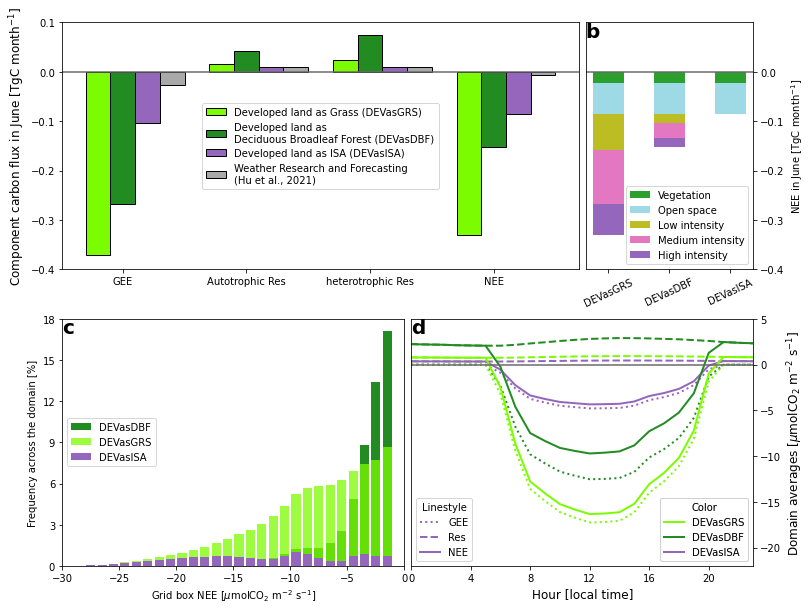

In [70]:
# Figure 1 - sensitivity of land cover
fig = plt.figure(figsize=(12, 10))
#from Read_WRF_VPRM
WRF_tot = [0.0261744016815, -0.020104814466/2.0, -0.020104814466/2.0, 0.006069586678875] 
NLCD_colors = [(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 
               (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), 
               (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), 
               (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), 
               (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0)]
gs = fig.add_gridspec(2,4)
gs.update(left=0.1, right=0.9, wspace=0.04, hspace=0.2)
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3])
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])

FontSize = 20
barWidth = 0.2
Ylim = -0.4
Ylim_hist = 18
labels = 'Vegetation', 'Open space', 'Low', 'Medium', 'High'

#-----------------------
# Bar sensitivity plots 
#-----------------------
br1 = np.arange(len(GRS_tot))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
ax1.bar(br1, -1*np.array(GRS_tot), color ='lawngreen', width = barWidth,
        edgecolor ='k', label ='Developed land as Grass (DEVasGRS)')
ax1.bar(br2, -1*np.array(DBF_tot), color ='forestgreen', width = barWidth,
        edgecolor ='k', label ='Developed land as \nDeciduous Broadleaf Forest (DEVasDBF)')
ax1.bar(br3, -1*np.array(ISA_tot), color ='tab:purple', width = barWidth,
        edgecolor ='k', label ='Developed land as ISA (DEVasISA)')
ax1.bar(br4, -1*np.array(WRF_tot), color ='darkgrey', width = barWidth,
        edgecolor ='k', label ='Weather Research and Forecasting \n(Hu et al., 2021)')
ax1.axhline(y=0, linestyle='-',color='dimgrey')
ax1.set_ylabel('Component carbon flux in June [TgC month$^{-1}$]', fontsize = FontSize-8)
ax1.set_xticks([r + barWidth for r in range(len(GRS_tot))],
        ['GEE', 'Autotrophic Res', 'heterotrophic Res', 'NEE'])
ax1.set_ylim(Ylim, 0.1)
ax1.set_yticks(np.arange(Ylim, 0.11, 0.1))
ax1.legend(loc='center')

#-----------------------
# Stacked bar plots
#-----------------------
FontSize = 12
barWidth = 0.5
barlabels = 'DEVasGRS','DEVasDBF','DEVasISA'
ax2.bar(barlabels, -veg_contr, label='Vegetation', color=NLCD_colors[0], width=barWidth)
ax2.bar(barlabels, -deo_contr, label='Open space', color=NLCD_colors[4], 
        bottom =-veg_contr, width=barWidth)
ax2.bar(barlabels, -del_contr, label='Low intensity', color=NLCD_colors[3],
       bottom =-veg_contr-deo_contr, width=barWidth)
ax2.bar(barlabels, -dem_contr, label='Medium intensity', color=NLCD_colors[2],
       bottom =-veg_contr-deo_contr-del_contr, width=barWidth)
ax2.bar(barlabels, -deh_contr, label='High intensity', color=NLCD_colors[1],
       bottom =-veg_contr-deo_contr-del_contr-dem_contr, width=barWidth)
ax2.axhline(y=0, linestyle='-',color='dimgrey')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(Ylim,0.1)
ax2.set_yticks(np.arange(Ylim,0.1,0.1))
ax2.set_ylabel('NEE in June [TgC month$^{-1}$]')
ax2.tick_params(axis='x', labelrotation =25)
ax2.legend(loc='lower right')

#-----------------------
#      Histograms
#-----------------------
bin_cen = np.array([(dbf_bin[i]+dbf_bin[i+1])/2.0 for i in range(0,len(dbf_bin)-1)])
ax3.bar(bin_cen, dbf_hist/np.size(NLCD_2D[NLCD_2D!=11])*100, color='forestgreen', 
        label='DEVasDBF')
ax3.bar(bin_cen, grs_hist/np.size(NLCD_2D[NLCD_2D!=11])*100, color='lawngreen', 
        alpha=0.75, label='DEVasGRS')
ax3.bar(bin_cen, isa_hist/np.size(NLCD_2D[NLCD_2D!=11])*100, color='tab:purple', 
        label='DEVasISA')
ax3.set_ylim(0, Ylim_hist)
ax3.set_xlim(-30, 0)
ax3.set_yticks(range(0, Ylim_hist+1, 3))
ax3.set_ylabel('Frequency across the domain [%]')
ax3.set_xlabel('Grid box NEE [$\mu$molCO$_{2}$ m$^{-2}$ s$^{-1}$]')
ax3.legend(loc='center left')

#-----------------------
#    Diurnal cycles
#-----------------------
LineWidth = 2
hours = range(0, 24)
# ISA case
h1,=ax4.plot(hours, GEE_ts_isa, color='tab:purple', label='GEE', linewidth=LineWidth, 
        linestyle='dotted')
h2,=ax4.plot(hours, Res_ts_isa, color='tab:purple', label='Res', linewidth=LineWidth,
       linestyle='--')
h3,=ax4.plot(hours, NEE_ts_isa, color='tab:purple', label='NEE', linewidth=LineWidth,
       linestyle='-')
# DBF case 
ax4.plot(hours, GEE_ts_dbf, color='forestgreen', label='GEE', linestyle='dotted', linewidth=LineWidth)
ax4.plot(hours, Res_ts_dbf, color='forestgreen', label='Res', linestyle='--', linewidth=LineWidth)
h4,=ax4.plot(hours, NEE_ts_dbf, color='forestgreen', label='NEE', linestyle='-', linewidth=LineWidth)
# GRS case
ax4.plot(hours, GEE_ts_grs, color='lawngreen', label='GEE', linestyle='dotted', linewidth=LineWidth)
ax4.plot(hours, Res_ts_grs, color='lawngreen', label='Res', linestyle='--', linewidth=LineWidth)
h5,=ax4.plot(hours, NEE_ts_grs, color='lawngreen', label='NEE', linestyle='-', linewidth=LineWidth)
ax4.axhline(y=0, color='dimgrey', linestyle='-')
ax4.set_xticks(range(0, 24, 4))
ax4.set_ylabel('Domain averages [$\mu$molCO$_{2}$ m$^{-2}$ s$^{-1}$]', fontsize = FontSize)
ax4.set_xlabel('Hour [local time]', fontsize = FontSize)
ax4.legend(loc=0)
ax4.set_ylim(-22,5)
ax4.set_xlim(0,23)
legend1=ax4.legend([h1,h2,h3],['GEE','Res','NEE'], loc=0, title='Linestyle')
legend2=ax4.legend([h5,h4,h3],['DEVasGRS','DEVasDBF','DEVasISA'],loc='lower right',title='Color')
ax4.add_artist(legend2)
ax4.add_artist(legend1)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()

# Panel numbers
txtx=0.0
txty=0.94
# ax1.text(0, txty, 'a', transform=ax1.transAxes, fontsize=20, fontweight='bold')
ax2.text(0, txty, 'b', transform=ax2.transAxes, fontsize=20, fontweight='bold')
ax3.text(0, txty, 'c', transform=ax3.transAxes, fontsize=20, fontweight='bold')
ax4.text(0, txty, 'd', transform=ax4.transAxes, fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()
fig.savefig(FigDir+'fig2_land_sensitivity_totCarbon.png')


(1560, 1546)


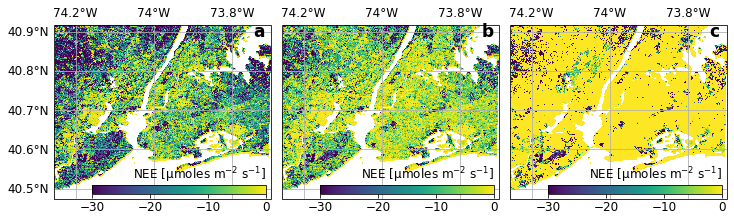

In [71]:
# A snapshot of the GEE, Res, and NEE
Datetime  = dt.datetime(2021, 6, 27, 12, 0, 0)
time_ind  = np.where(time_grs==dt.datetime.timestamp(Datetime))
time_ind  = np.array(time_ind)[0][0]

GEE_grs_hr  = GEE_grs[time_ind,:,:]   #TMP_uhi_time_ave  #NEE_grs_time_ave #[time_ind,:,:]
Res_grs_hr  = Res_grs[time_ind,:,:]   #NEE_dbf_time_ave #[time_ind,:,:]
NEE_grs_hr  = NEE_grs[time_ind,:,:]   #[time_ind,:,:]

GEE_dbf_hr  = GEE_dbf[time_ind,:,:]   #TMP_uhi_time_ave  #NEE_grs_time_ave #[time_ind,:,:]
Res_dbf_hr  = Res_dbf[time_ind,:,:]   #NEE_dbf_time_ave #[time_ind,:,:]
NEE_dbf_hr  = NEE_dbf[time_ind,:,:]   #[time_ind,:,:]

GEE_isa_hr  = GEE_isa[time_ind,:,:]   #TMP_uhi_time_ave  #NEE_grs_time_ave #[time_ind,:,:]
Res_isa_hr  = Res_isa[time_ind,:,:]   #NEE_dbf_time_ave #[time_ind,:,:]
NEE_isa_hr  = NEE_isa[time_ind,:,:]   #[time_ind,:,:]

# Read the center lat lon for the NYC-domain
df=pd.read_csv('/data0/dwei/VPRMout/NYC_domain_center_latlon')
#print(df.head())
center_lat = df.to_numpy()[:,1]
center_lon = df.to_numpy()[:,2]

# Plotting NLCD, ISA, EVI
fig = plt.figure(figsize=(11, 5))
gs = fig.add_gridspec(1,3)
fig.subplots_adjust(hspace=-0.45, wspace=0.05, top=0.95, bottom=0.1, right=0.95, left=0.1)
FontSize=12
row = 2
col = 2
Vmin= -30
Vmax= 0
Cmap = 'viridis' #'viridis'
extent = [min(center_lon)-0.001, max(center_lon),min(center_lat)-0.02, max(center_lat)]

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# NEE_grs_hr
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax1.set_extent(extent, crs=ccrs.PlateCarree())
cc = ax1.pcolormesh(center_lon.reshape(1560, 1546), center_lat.reshape(1560, 1546),NEE_grs_hr, 
               transform=ccrs.PlateCarree(),vmin=Vmin, vmax = Vmax, cmap=Cmap)
# Colorbar inside figure
axins1 = inset_axes(ax1,
                    width="80%",  # width = 50% of parent_bbox width
                    height="5%",  
                    loc='lower right')
cbar = plt.colorbar(cc, cax=axins1, orientation="horizontal", ticks=range(Vmin,Vmax+1,10))  
axins1.xaxis.set_ticks_position("bottom")
cbar.ax.set_title('NEE [\u03BCmoles m$^{-2}$ s$^{-1}$]', loc='right', fontsize=FontSize)
cbar.ax.tick_params(labelsize=FontSize) 
# Axis labels
gl=ax1.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.bottom_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-74.2, -74, -73.8])
gl.xlabel_style = {'size':FontSize}
gl.ylabel_style = {'size':FontSize}

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# NEE_dbf_hr
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax2.set_extent(extent, crs=ccrs.PlateCarree())
cc = ax2.pcolormesh(center_lon.reshape(1560, 1546), center_lat.reshape(1560, 1546),NEE_dbf_hr, 
               transform=ccrs.PlateCarree(),vmin=Vmin, vmax = Vmax, cmap=Cmap)
# Colorbar inside figure
axins1 = inset_axes(ax2,
                    width="80%",  # width = 50% of parent_bbox width
                    height="5%",  
                    loc='lower right')
cbar = plt.colorbar(cc, cax=axins1, orientation="horizontal", ticks=range(Vmin,Vmax+1,10))  
axins1.xaxis.set_ticks_position("bottom")
cbar.ax.set_title('NEE [\u03BCmoles m$^{-2}$ s$^{-1}$]', loc='right', fontsize=FontSize)
cbar.ax.tick_params(labelsize=FontSize) 
# Axis labels
gl=ax2.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-74.2, -74, -73.8])
gl.xlabel_style = {'size':FontSize}
gl.ylabel_style = {'size':FontSize}

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# NEE_isa_hr
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax3 = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())
ax3.set_extent(extent, crs=ccrs.PlateCarree())
cc = ax3.pcolormesh(center_lon.reshape(1560, 1546), center_lat.reshape(1560, 1546),NEE_isa_hr, 
               transform=ccrs.PlateCarree(),vmin=Vmin, vmax = Vmax, cmap=Cmap)
# Colorbar inside figure
axins1 = inset_axes(ax3,
                    width="80%",  # width = 50% of parent_bbox width
                    height="5%",  
                    loc='lower right')
cbar = plt.colorbar(cc, cax=axins1, orientation="horizontal", ticks=range(Vmin,Vmax+1,10))  
axins1.xaxis.set_ticks_position("bottom")
cbar.ax.set_title('NEE [\u03BCmoles m$^{-2}$ s$^{-1}$]', loc='right', fontsize=FontSize)
cbar.ax.tick_params(labelsize=FontSize) 
# Axis labels
gl=ax3.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-74.2, -74.0, -73.8])
gl.xlabel_style = {'size':FontSize}

#panels
txtx=0.92
txty=0.93
ax1.text(txtx, txty, 'a', transform=ax1.transAxes, fontsize = FontSize+5, fontweight='bold')
ax2.text(txtx, txty, 'b', transform=ax2.transAxes, fontsize = FontSize+5, fontweight='bold')
ax3.text(txtx, txty, 'c', transform=ax3.transAxes, fontsize = FontSize+5, fontweight='bold')

fig.savefig(FigDir+'fig3_NEE_map.png')


(40,)
[    0     0     0     0     0     3     6    18    52    97   199   407
   797  1313  2209  3318  4952  6201  7762  8873  9804 10791 11652 12022
 11829 11123  9658  8649  8764 12235 17234 15255 10007  6791  6177 11888
 15425 11829 11746]
[20 21 22 23 24]


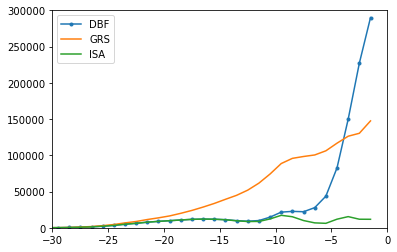

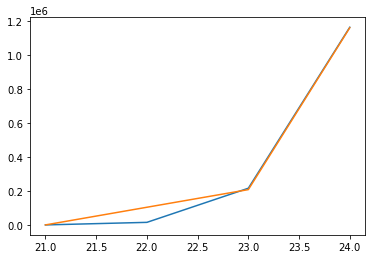

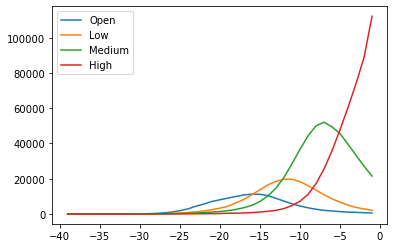

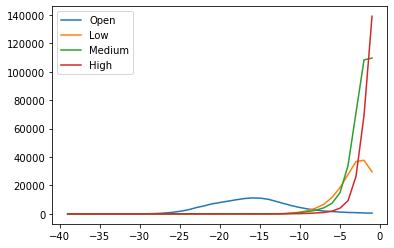

In [9]:
# can be deleted; for writing
print(np.shape(dbf_bin))
print(isa_hist)

bin_cen = np.array([(dbf_bin[i]+dbf_bin[i+1])/2.0 for i in range(0,len(dbf_bin)-1)])
plt.figure()
plt.plot(bin_cen, dbf_hist, label='DBF',marker='.')
plt.plot(bin_cen, grs_hist, label='GRS')
plt.plot(bin_cen, isa_hist, label='ISA')
plt.legend()
plt.ylim(-1,3e5)
plt.xlim(-30,0)

NLCD_dbf = NLCD_2D[NEE_dbf_time_ave>-10]
NLCD_grs = NLCD_2D[NEE_grs_time_ave>-20]

hist_dbf, lc_bin = np.histogram(NLCD_dbf, bins=range(20, 25))
hist_grs, lc_bin = np.histogram(NLCD_grs, bins=range(20, 25))
print(lc_bin)
plt.figure()
plt.plot(lc_bin[1:], hist_dbf, label='DBF')
plt.plot(lc_bin[1:], hist_grs, label='GRS')

hist_tst, bin_tst = np.histogram(NEE_grs_time_ave[NLCD_2D==21], bins=range(-40, 0))
hist_tst2, bin_tst2 = np.histogram(NEE_grs_time_ave[NLCD_2D==22], bins=range(-40, 0))
hist_tst3, bin_tst3 = np.histogram(NEE_grs_time_ave[NLCD_2D==23], bins=range(-40, 0))
hist_tst4, bin_tst4 = np.histogram(NEE_grs_time_ave[NLCD_2D==24], bins=range(-40, 0))
plt.figure()
plt.plot(bin_tst[1:], hist_tst, label='Open')
plt.plot(bin_tst2[1:], hist_tst2, label='Low')
plt.plot(bin_tst3[1:], hist_tst3, label='Medium')
plt.plot(bin_tst4[1:], hist_tst4, label='High')
plt.legend()

hist_tst, bin_tst = np.histogram(NEE_dbf_time_ave[NLCD_2D==21], bins=range(-40, 0))
hist_tst2, bin_tst2 = np.histogram(NEE_dbf_time_ave[NLCD_2D==22], bins=range(-40, 0))
hist_tst3, bin_tst3 = np.histogram(NEE_dbf_time_ave[NLCD_2D==23], bins=range(-40, 0))
hist_tst4, bin_tst4 = np.histogram(NEE_dbf_time_ave[NLCD_2D==24], bins=range(-40, 0))
plt.figure()
plt.plot(bin_tst[1:], hist_tst, label='Open')
plt.plot(bin_tst2[1:], hist_tst2, label='Low')
plt.plot(bin_tst3[1:], hist_tst3, label='Medium')
plt.plot(bin_tst4[1:], hist_tst4, label='High')
plt.legend()


In [10]:
##########################################################
#                                                        #
#              Urban heat island effects                 #
#                                                        #
##########################################################
# Load NetCDF files for hotter
# filepath_uhi = VPRMoutDir+'UHI_20220222.nc' 
# filepath_uhi6 = VPRMoutDir+'UHI_6C_20220222.nc' 
# filepath_uhictrl = VPRMoutDir+'UHI_control_20220222.nc'

# filepath_uhictrl =  VPRMoutDir+'UHIdefaut_for0801_20220303.nc'
# filepath_uhi  =  VPRMoutDir+'UHI4C_for0801_20220303.nc'
# filepath_uhi6 = VPRMoutDir+'UHI6C_for0801_20220303.nc'

# DEL,DEM,DEH ----> DBF
filepath_uhictrl =  VPRMoutDir+'UHIctrl_heatwave0629_20220310.nc'
filepath_uhi  =  VPRMoutDir+'UHI4C_heatwave0629_20220310.nc'
filepath_uhi6 = VPRMoutDir+'UHI6C_heatwave0629_20220314.nc'

# # DEL,DEM,DEH ----> GRS
# filepath_uhictrl =  VPRMoutDir+'UHIctrl_heatwave0629_GRS_20220317.nc'
# filepath_uhi  =  VPRMoutDir+'UHI4C_heatwave0629_GRS_20220317.nc'
# filepath_uhi6 = VPRMoutDir+'UHI6C_heatwave0629_GRS_20220317.nc'
GEE_uhi, Resh_uhi, Resa_uhi, NEE_uhi, time_uhi, Xdim_uhi, Ydim_uhi, TMP_uhi = \
                                        Read_VPRMout(filepath_uhi)
GEE_uhi6, Resh_uhi6, Resa_uhi6, NEE_uhi6, time_uhi6, Xdim_uhi6, Ydim_uhi6, TMP_uhi6 = \
                                        Read_VPRMout(filepath_uhi6)
GEE_uctrl, Resh_uctrl, Resa_uctrl, NEE_uctrl, time_uctrl, Xdim_uctrl, Ydim_uctrl, TMP_uctrl = \
                                        Read_VPRMout(filepath_uhictrl)

Res_uhi=Resh_uhi+Resa_uhi
Res_uhi6=Resh_uhi6+Resa_uhi6
Res_uctrl=Resh_uctrl+Resa_uctrl

GEE_uhi[:, water_boo] = np.nan
Res_uhi[:, water_boo] = np.nan
NEE_uhi[:, water_boo] = np.nan

GEE_uhi6[:, water_boo] = np.nan
Res_uhi6[:, water_boo] = np.nan
NEE_uhi6[:, water_boo] = np.nan

GEE_uctrl[:, water_boo] = np.nan
Res_uctrl[:, water_boo] = np.nan
NEE_uctrl[:, water_boo] = np.nan

TMP_uhi[:, water_boo] = np.nan
TMP_uhi6[:, water_boo] = np.nan
TMP_uctrl[:, water_boo] = np.nan

def get_domain_averages(hr_range):
    
    # The averages along the time axis
    GEE_uhi_time_ave = get_first_dimension_ave(GEE_uhi[hr_range,:,:])
    GEE_uhi6_time_ave = get_first_dimension_ave(GEE_uhi6[hr_range,:,:])
    GEE_uct_time_ave = get_first_dimension_ave(GEE_uctrl[hr_range,:,:])

    Res_uhi_time_ave = get_first_dimension_ave(Res_uhi[hr_range,:,:])
    Res_uhi6_time_ave = get_first_dimension_ave(Res_uhi6[hr_range,:,:])
    Res_uct_time_ave = get_first_dimension_ave(Res_uctrl[hr_range,:,:])

    NEE_uhi_time_ave = get_first_dimension_ave(NEE_uhi[hr_range,:,:])
    NEE_uhi6_time_ave = get_first_dimension_ave(NEE_uhi6[hr_range,:,:])
    NEE_uct_time_ave = get_first_dimension_ave(NEE_uctrl[hr_range,:,:])

    TMP_uhi_time_ave = get_first_dimension_ave(TMP_uhi[hr_range,:,:])
    TMP_uhi6_time_ave = get_first_dimension_ave(TMP_uhi6[hr_range,:,:])
    TMP_uct_time_ave = get_first_dimension_ave(TMP_uctrl[hr_range,:,:])

    # The domain mean&STD (daily mean)
    GEE_uhi_ave = np.nanmean(GEE_uhi_time_ave)  
    GEE_uhi6_ave = np.nanmean(GEE_uhi6_time_ave)  
    GEE_uct_ave = np.nanmean(GEE_uct_time_ave) 
    GEE_uhi_std = np.nanstd(GEE_uhi_time_ave)   # variability across the domain
    GEE_uhi6_std = np.nanstd(GEE_uhi6_time_ave)
    GEE_uct_std = np.nanstd(GEE_uct_time_ave) 

    Res_uhi_ave = np.nanmean(Res_uhi_time_ave)  
    Res_uhi6_ave = np.nanmean(Res_uhi6_time_ave) 
    Res_uct_ave = np.nanmean(Res_uct_time_ave) 
    Res_uhi_std = np.nanstd(Res_uhi_time_ave)   # variability across the domain
    Res_uhi6_std = np.nanstd(Res_uhi6_time_ave)
    Res_uct_std = np.nanstd(Res_uct_time_ave)

    NEE_uhi_ave = np.nanmean(NEE_uhi_time_ave)   
    NEE_uhi6_ave = np.nanmean(NEE_uhi6_time_ave) 
    NEE_uct_ave = np.nanmean(NEE_uct_time_ave) 
    NEE_uhi_std = np.nanstd(NEE_uhi_time_ave)   # variability across the domain
    NEE_uhi6_std = np.nanstd(NEE_uhi6_time_ave)
    NEE_uct_std = np.nanstd(NEE_uct_time_ave)

    TMP_uhi_ave = np.nanmean(TMP_uhi_time_ave)
    TMP_uhi6_ave = np.nanmean(TMP_uhi6_time_ave)
    TMP_uct_ave = np.nanmean(TMP_uct_time_ave)
    TMP_uhi_std = np.nanstd(TMP_uhi_time_ave)
    TMP_uhi6_std = np.nanstd(TMP_uhi6_time_ave)
    TMP_uct_std = np.nanstd(TMP_uct_time_ave)

    # NAs percentage check
    # 30% is normal because that's the water percentage
    print('NAs check :', np.size(NEE_uhi_time_ave[np.isnan(NEE_uhi_time_ave)])/2411760)
    print('NAs check :', np.size(NEE_uct_time_ave[np.isnan(NEE_uct_time_ave)])/2411760)
    print('NAs check :', np.size(NEE_uhi6_time_ave[np.isnan(NEE_uhi6_time_ave)])/2411760)

    # Construct the lists for bar plots
    UHI_ave = [-GEE_uhi_ave, Res_uhi_ave, -NEE_uhi_ave]
    UHI6_ave = [-GEE_uhi6_ave, Res_uhi6_ave, -NEE_uhi6_ave]
    UCT_ave = [-GEE_uct_ave, Res_uct_ave, -NEE_uct_ave]

    UHI_std = [(-GEE_uhi_std, -Res_uhi_std, -NEE_uhi_std),(0,0,0)]
    UHI6_std = [(-GEE_uhi6_std, -Res_uhi6_std, -NEE_uhi6_std),(0,0,0)]
    UCT_std = [(-GEE_uct_std, -Res_uct_std, -NEE_uct_std),(0,0,0)]
    
    return UHI_ave, UHI6_ave, UCT_ave, UHI_std, UHI6_std, UCT_std

# For the bar plots
day_hr = range(6,19)
nig_hr = range(0, 6)
diel_hr = range(0,24)
UHI_ave, UHI6_ave, UCT_ave, UHI_std, UHI6_std, UCT_std = get_domain_averages(diel_hr)
UHI_ave_day, UHI6_ave_day, UCT_ave_day, UHI_std_day, UHI6_std_day, UCT_std_day = get_domain_averages(day_hr)
UHI_ave_nig, UHI6_ave_nig, UCT_ave_nig, UHI_std_nig, UHI6_std_nig, UCT_std_nig = get_domain_averages(nig_hr)


NAs check : 0.3054565960128703
NAs check : 0.3054565960128703
NAs check : 0.3054565960128703
NAs check : 0.3054565960128703
NAs check : 0.3054565960128703
NAs check : 0.3054565960128703
NAs check : 0.3054565960128703
NAs check : 0.3054565960128703
NAs check : 0.3054565960128703


In [11]:
# Analysis for the supplementary figures to explain the different UHI scenarios
delT   = TMP_uhi6 - TMP_uctrl
delGEE = -GEE_uhi6 + GEE_uctrl
delRes =  Res_uctrl-Res_uhi6
delNEE = -NEE_uhi6 + NEE_uctrl

# The averages along the time axis (diel)
delT_time_ave =  delT[14, :, :]    #np.nanmean(delT, axis=0)
delGEE_time_ave = delGEE[14, :, :] #np.nanmean(delGEE, axis=0)
delRes_time_ave = delRes[14, :, :] #np.nanmean(delRes, axis=0)
delNEE_time_ave = delNEE[14, :, :] #np.nanmean(delNEE, axis=0)

def get_deltaX_landtype(lst, deltaX):
    # Need to have NLCD_2D set up
    # The absolute deltaX
    delta_arr = []
    delta_arr_std = []
    for x in lst:
        delta_arr.append(np.nanmean(deltaX[NLCD_2D==x]))
        delta_arr_std.append(np.nanstd(deltaX[NLCD_2D==x]))
    return delta_arr,delta_arr_std

def get_deltaX_contribution(lst, deltaX):
    # Need to have NLCD_2D set up
    # The contribution to the domain
    delta_arr = []
    delta_arr_std = []
    for x in lst:
        delta_arr.append(np.nansum(deltaX[NLCD_2D==x])/np.size(NLCD[NLCD!=11]))
        delta_arr_std.append(np.nanstd(deltaX[NLCD_2D==x])/np.size(NLCD[NLCD!=11]))
    return delta_arr,delta_arr_std

def get_deltaX_ISA(delISA, var):
    var_ave = []
    var_std = []
    for x in range(20, 100+delISA, delISA):
        tmp = np.nanmedian(var[IPSA_2D==x])
        tmps = np.nanstd(var[IPSA_2D==x])
        var_ave.append(tmp)
        var_std.append(tmps)
    return np.array(var_ave), np.array(var_std)

landtype_lst = [41, 21, 22, 23, 24]
# Increase in each land type
detT_landtype,detT_landtype_std = get_deltaX_landtype(landtype_lst, delT_time_ave)
detG_landtype,detG_landtype_std = get_deltaX_landtype(landtype_lst, delGEE_time_ave)
detR_landtype,detR_landtype_std = get_deltaX_landtype(landtype_lst, delRes_time_ave)
detN_landtype,detN_landtype_std = get_deltaX_landtype(landtype_lst, delNEE_time_ave)

# Contribution from each land type to the domain-average fluxes
detT_contrb,detT_contrb_std = get_deltaX_contribution(landtype_lst, delT_time_ave)
detG_contrb,detG_contrb_std = get_deltaX_contribution(landtype_lst, delGEE_time_ave)
detR_contrb,detR_contrb_std = get_deltaX_contribution(landtype_lst, delRes_time_ave)
detN_contrb,detN_contrb_std = get_deltaX_contribution(landtype_lst, delNEE_time_ave)

# The changes of each ISA
delISA = 1
absT_isa_ave,absT_isa_std = get_deltaX_ISA(delISA, TMP_uhi6[14, :, :])
delT_isa_ave,delT_isa_std = get_deltaX_ISA(delISA, delT_time_ave)
delG_isa_ave,delG_isa_std = get_deltaX_ISA(delISA, delGEE_time_ave)
delR_isa_ave,delR_isa_std = get_deltaX_ISA(delISA, delRes_time_ave)
delN_isa_ave,delN_isa_std = get_deltaX_ISA(delISA, delNEE_time_ave)

EVI_isa_ave,EVI_isa_std = get_deltaX_ISA(delISA, EVI_2D)


/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/numpy/lib/function_base.py:3685: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


<ErrorbarContainer object of 3 artists>

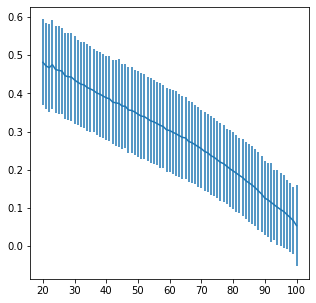

In [12]:
# EVI as a function of ISA
Xaxis = range(20, 100+delISA, delISA)
plt.figure(figsize=(5,5))
plt.errorbar(Xaxis, EVI_isa_ave, yerr=EVI_isa_std)

In [13]:
# Diurnal variations of domain averages
print(np.shape(NEE_uhi6))
hours = range(0, 24)

def get_diurnal_time_series(GEE_3D, Res_3D, NEE_3D):    
    GEE_ts =[]
    Res_ts =[]
    NEE_ts =[]
    for i in range(0, 24):
        GEE_ts.append(np.nanmean(GEE_3D[i, :, :]))
        Res_ts.append(np.nanmean(Res_3D[i, :, :]))
        NEE_ts.append(np.nanmean(NEE_3D[i, :, :]))
    return np.array(GEE_ts),np.array(Res_ts),np.array(NEE_ts)

def get_diurnal_time_series_std(GEE_3D, Res_3D, NEE_3D):    
    GEE_ts =[]
    Res_ts =[]
    NEE_ts =[]
    for i in range(0, 24):
        GEE_ts.append(np.nanstd(GEE_3D[i, :, :]))
        Res_ts.append(np.nanstd(Res_3D[i, :, :]))
        NEE_ts.append(np.nanstd(NEE_3D[i, :, :]))
    return np.array(GEE_ts),np.array(Res_ts),np.array(NEE_ts)

GEE_ts_ctrl,Res_ts_ctrl,NEE_ts_ctrl = get_diurnal_time_series(GEE_uctrl, Res_uctrl, NEE_uctrl)
GEE_ts_uhi,Res_ts_uhi,NEE_ts_uhi = get_diurnal_time_series(GEE_uhi, Res_uhi, NEE_uhi)
GEE_ts_uhi6,Res_ts_uhi6,NEE_ts_uhi6 = get_diurnal_time_series(GEE_uhi6, Res_uhi6, NEE_uhi6)

GEE_ts_ctrl_std,Res_ts_ctrl_std,NEE_ts_ctrl_std = get_diurnal_time_series_std(GEE_uctrl, Res_uctrl, NEE_uctrl)
GEE_ts_uhi_std,Res_ts_uhi_std,NEE_ts_uhi_std = get_diurnal_time_series_std(GEE_uhi, Res_uhi, NEE_uhi)
GEE_ts_uhi6_std,Res_ts_uhi6_std,NEE_ts_uhi6_std = get_diurnal_time_series_std(GEE_uhi6, Res_uhi6, NEE_uhi6)



(24, 1560, 1546)


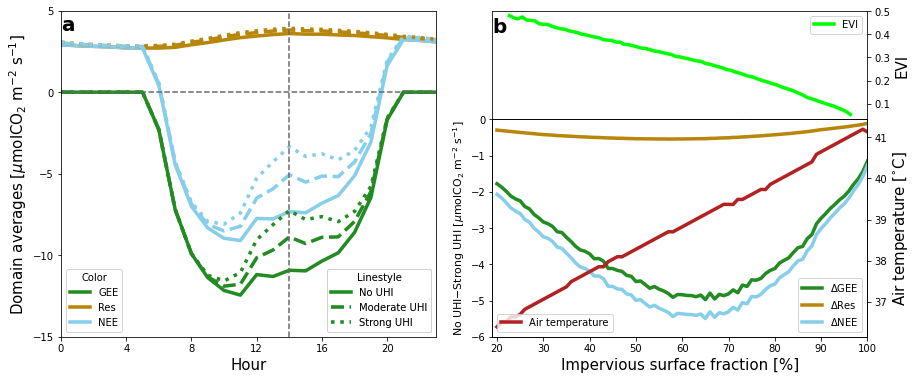

<Figure size 432x288 with 0 Axes>

In [14]:
# Figure 3 - UHI sensitivity analysis
fig= plt.figure(figsize =(14, 6))
gs = fig.add_gridspec(3,2)
gs.update(left=0.1, right=0.9, wspace=0.15, hspace=0.)
ax1 = fig.add_subplot(gs[:, 0])   # diurnal
ax2 = fig.add_subplot(gs[0, 1])   # EVI
ax3 = fig.add_subplot(gs[1:3, 1]) # delGEE, delNEE, delRes

Xaxis = range(20, 100+delISA, delISA)
barWidth = 0.15
br1 = np.arange(len(UHI_ave))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# gs = fig.add_gridspec(1)
LineWidth=3.5
FontSize = 15
barWidth = 0.15
Ylim = 15
Ylim2 = 6
explode = [0,0,0,0,0]
labels = 'Vegetation', 'Open space', 'Low', 'Medium', 'High'
colours = {'Vegetation':'forestgreen',
          'Open space':'thistle',
          'Low':'violet',
          'Medium':'darkviolet',
          'High':'indigo'}

# Diurnal cycles of domain averages
# ax[0].set_title('Diurnal variations of domain-averaged GEE, Res, NEE')
# Control
h1,=ax1.plot(hours, GEE_ts_ctrl, color='forestgreen',  label='GEE',linewidth=LineWidth)
h2,=ax1.plot(hours, Res_ts_ctrl, color='darkgoldenrod', label='Res',  linewidth=LineWidth)
h3,=ax1.plot(hours, NEE_ts_ctrl, color='skyblue', label='NEE', linewidth=LineWidth)
# UHI
h4,=ax1.plot(hours, GEE_ts_uhi, color='forestgreen',  linestyle='--', linewidth=LineWidth)
ax1.plot(hours, Res_ts_uhi, color='darkgoldenrod', label='_nolegend_', linestyle='--', linewidth=LineWidth)
ax1.plot(hours, NEE_ts_uhi, color='skyblue', label='_nolegend_', linestyle='--', linewidth=LineWidth)
# UHI6
h5,=ax1.plot(hours, GEE_ts_uhi6, color='forestgreen',  linestyle='dotted', linewidth=LineWidth)
ax1.plot(hours, Res_ts_uhi6, color='darkgoldenrod',label='_nolegend_', linestyle='dotted', linewidth=LineWidth)
ax1.plot(hours, NEE_ts_uhi6, color='skyblue', label='_nolegend_', linestyle='dotted', linewidth=LineWidth)

ax1.axhline(y=0,color='dimgrey',linestyle='--')
ax1.axvline(x=14,color='dimgrey',linestyle='--')
ax1.set_ylabel('Domain averages [$\mu$molCO$_{2}$ m$^{-2}$ s$^{-1}$]', fontsize = FontSize)
ax1.set_xlabel('Hour', fontsize = FontSize)

legend1=ax1.legend([h1,h2,h3],['GEE','Res','NEE'], loc=0, title='Color')
legend2=ax1.legend([h1,h4,h5],['No UHI','Moderate UHI','Strong UHI'],
                     loc='lower right',title='Linestyle')
ax1.add_artist(legend2)
ax1.add_artist(legend1)

ax1.set_ylim(-15, 5)
ax1.set_yticks(range(-15, 5+1, 5))
ax1.set_xlim(0, 23)
ax1.set_xticks(range(0, 24, 4))

#EVI
ax2.plot(Xaxis, EVI_isa_ave, label='EVI', color='lime',linewidth=LineWidth)
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.set_ylabel('EVI', fontsize=FontSize)
ax2.legend(loc='upper right')

# Changes as a function of ISA 
ax3.plot(Xaxis, delG_isa_ave, label='$\Delta$GEE', color='forestgreen',
          linewidth=LineWidth)
ax3.plot(Xaxis, delR_isa_ave, label='$\Delta$Res',color='darkgoldenrod',
               linewidth=LineWidth)
ax3.plot(Xaxis, delN_isa_ave, label='$\Delta$NEE', color='skyblue',
           linewidth=LineWidth)

ax3.axhline(y=0, color='dimgrey', linestyle='--')
ax3.set_ylim(-Ylim2, 0)
ax3.set_xlim(19, 100)
ax3.set_xlabel('Impervious surface fraction [%]', fontsize = FontSize)
ax3.set_ylabel('No UHI$-$Strong UHI [$\mu$molCO$_{2}$ m$^{-2}$ s$^{-1}$]', 
               fontsize = FontSize-4)
ax3.legend(loc='lower right')

ax3twin=ax3.twinx()
ax3twin.plot(Xaxis, absT_isa_ave, label='Air temperature', color='firebrick',linewidth=LineWidth)
ax3twin.set_ylabel('Air temperature [$^{\circ}$C]', fontsize = FontSize)
ax3twin.legend(loc='lower left')

ax1.text(0,0.94, 'a', transform=ax1.transAxes,fontsize=20, fontweight='bold')
ax2.text(0,0.8, 'b', transform=ax2.transAxes,fontsize=20, fontweight='bold')

plt.show()
plt.tight_layout()
FigDir = '/home/dwei/manuscripts/VPRM-sensitivity/fig/'
fig.savefig(FigDir+'fig3_UHI_sensitivity_DBF_ISA20.png')
            

In [15]:
##########################################################
#                                                        #
#            Grass vs Deciduous vs Wetland               #
#                                                        #
##########################################################

# Load NetCDF files
VPRMoutDir = '/data0/dwei/VPRMout/'
GEE_grs, Res_grs, NEE_grs, time_grs, Xdim_grs, Ydim_grs, TMP_grs = \
                    Read_VPRMout(VPRMoutDir+'GRS_devDBF_20220223.nc' )
GEE_dbf, Res_dbf, NEE_dbf, time_dbf, Xdim_dbf, Ydim_dbf, TMP_dbf = \
                    Read_VPRMout(VPRMoutDir+'DBF_devDBF_20220223.nc' )
GEE_wet, Res_wet, NEE_wet, time_wet, Xdim_wet, Ydim_wet, TMP_wet = \
                    Read_VPRMout(VPRMoutDir+'WET_devDBF_20220223.nc' )

# set water to nan
water_boo = NLCD_2D==11 
NEE_grs[:, water_boo] = np.nan
NEE_dbf[:, water_boo] = np.nan
NEE_wet[:, water_boo] = np.nan

GEE_grs[:, water_boo] = np.nan
GEE_dbf[:, water_boo] = np.nan
GEE_wet[:, water_boo] = np.nan

Res_grs[:, water_boo] = np.nan
Res_dbf[:, water_boo] = np.nan
Res_wet[:, water_boo] = np.nan

# set water to nan
water_boo = NLCD_2D==11 
NEE_grs[:, water_boo] = np.nan
NEE_dbf[:, water_boo] = np.nan
NEE_isa[:, water_boo] = np.nan

GEE_grs[:, water_boo] = np.nan
GEE_dbf[:, water_boo] = np.nan
GEE_isa[:, water_boo] = np.nan

Res_grs[:, water_boo] = np.nan
Res_dbf[:, water_boo] = np.nan
Res_isa[:, water_boo] = np.nan

# set water to nan
water_boo = NLCD_2D==11 
NEE_grs[:, water_boo] = np.nan
NEE_dbf[:, water_boo] = np.nan
NEE_wet[:, water_boo] = np.nan

GEE_grs[:, water_boo] = np.nan
GEE_dbf[:, water_boo] = np.nan
GEE_wet[:, water_boo] = np.nan

Res_grs[:, water_boo] = np.nan
Res_dbf[:, water_boo] = np.nan
Res_wet[:, water_boo] = np.nan

# Take the mean along the time axis
GEE_grs_time_ave = get_first_dimension_ave(GEE_grs)
GEE_dbf_time_ave = get_first_dimension_ave(GEE_dbf)
GEE_wet_time_ave = get_first_dimension_ave(GEE_wet)

Res_grs_time_ave = get_first_dimension_ave(Res_grs)
Res_dbf_time_ave = get_first_dimension_ave(Res_dbf)
Res_wet_time_ave = get_first_dimension_ave(Res_wet)

NEE_grs_time_ave = get_first_dimension_ave(NEE_grs)
NEE_dbf_time_ave = get_first_dimension_ave(NEE_dbf)
NEE_wet_time_ave = get_first_dimension_ave(NEE_wet)

# Take teh domain mean&std
GEE_grs_ave = np.nanmean(GEE_grs_time_ave)   
GEE_dbf_ave = np.nanmean(GEE_dbf_time_ave) 
GEE_wet_ave = np.nanmean(GEE_wet_time_ave) 
GEE_grs_std = np.nanstd(GEE_grs_time_ave)  # variability across the domain
GEE_dbf_std = np.nanstd(GEE_dbf_time_ave) 
GEE_wet_std = np.nanstd(GEE_wet_time_ave) 

Res_grs_ave = np.nanmean(Res_grs_time_ave)   
Res_dbf_ave = np.nanmean(Res_dbf_time_ave) 
Res_wet_ave = np.nanmean(Res_wet_time_ave) 
Res_grs_std = np.nanstd(Res_grs_time_ave)   
Res_dbf_std = np.nanstd(Res_dbf_time_ave) 
Res_wet_std = np.nanstd(Res_wet_time_ave) 

NEE_grs_ave = np.nanmean(NEE_grs_time_ave)
NEE_dbf_ave = np.nanmean(NEE_dbf_time_ave)
NEE_wet_ave = np.nanmean(NEE_wet_time_ave) 
NEE_grs_std = np.nanstd(NEE_grs_time_ave)
NEE_dbf_std = np.nanstd(NEE_dbf_time_ave)
NEE_wet_std = np.nanstd(NEE_wet_time_ave)

# NAs percentage check
print('NAs check :', np.size(NEE_grs_time_ave[np.isnan(NEE_grs_time_ave)])/2411760)
print('NAs check :', np.size(NEE_dbf_time_ave[np.isnan(NEE_dbf_time_ave)])/2411760)
print('NAs check :', np.size(NEE_wet_time_ave[np.isnan(NEE_wet_time_ave)])/2411760)

# Construct the lists for bar plots
GRS_ave = [-GEE_grs_ave, Res_grs_ave, -NEE_grs_ave]
DBF_ave = [-GEE_dbf_ave, Res_dbf_ave, -NEE_dbf_ave]
WET_ave = [-GEE_wet_ave, Res_wet_ave, -NEE_wet_ave]

GRS_std = [(-GEE_grs_std, -Res_grs_std, -NEE_grs_std),(0,0,0)]
DBF_std = [(-GEE_dbf_std, -Res_dbf_std, -NEE_dbf_std),(0,0,0)]
WET_std = [(-GEE_wet_std, -Res_wet_std, -NEE_wet_std),(0,0,0)]

WRF_ave = [0.5410874, 0.35278043, 0.18830702]
WRF_std = [(-0.56582195, -0.25775716, -0.37403858),(0,0,0)]
print('GEE : %f, %f, %f' %(GEE_grs_ave,GEE_dbf_ave,GEE_wet_ave))
print('Res : %f, %f, %f' %(Res_grs_ave,Res_dbf_ave,Res_wet_ave))
print('NEE : %f, %f, %f' %(NEE_grs_ave,NEE_dbf_ave,NEE_wet_ave))

# Bar plot
fig = plt.subplots(figsize =(10, 6))
barWidth = 0.2

# Set position of bar on X axis
br1 = np.arange(len(GRS_ave))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, GRS_ave, color ='lawngreen', width = barWidth, yerr=GRS_std,
        edgecolor ='k', label ='GRS')
plt.bar(br2, DBF_ave, color ='forestgreen', width = barWidth,yerr=DBF_std,
        edgecolor ='k', label ='DBF')
plt.bar(br3, WET_ave, color ='darkorange', width = barWidth,yerr=WET_std,
        edgecolor ='k', label ='WET')
plt.bar(br4, WRF_ave, color ='skyblue', width = barWidth,yerr=WRF_std,
        edgecolor ='k', label ='WRF')

# Adding Xticks
plt.xlabel('Land cover types', fontweight ='bold', fontsize = 15)
plt.ylabel('Model outputs [\u03BCmoles m$^{-2}$ s$^{-1}$]', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(GRS_ave))],
        ['GEE', 'RES', 'NEE'])
plt.ylim(0,15)
plt.yticks(range(0,15,2))

plt.legend()
plt.show()


ValueError: too many values to unpack (expected 7)

In [ ]:
# tree or notree
GEE = (5.737733-3.405099)/3.405099
Res = (-1.124381+1.492090)/1.124381
NEE = (4.613352-2.207494)/2.207494
print(GEE, Res, NEE)

# vegetated surfaces
GEE= (6.883070-2.295763)/2.295763
Res =(1.219344-0.286450)/0.286450
NEE = (6.275883-2.009313)/2.009313
print(GEE, Res, NEE)

In [ ]:
# Interpretation of VPRM outputs
# The GEE responses to land cover changes (i.e. changes in parameters)
PAR = np.arange(0, 1500.0)

GEE_prime_grs = 0.213/(1+PAR/542.0)*PAR
GEE_prime_dbf = 0.09355/(1+PAR/863.0)*PAR
GEE_prime_dbf_old = 0.127/(1+PAR/570.0)*PAR

fig, ax = plt.subplots()
grs = ax.plot(PAR, GEE_prime_grs, label='GRS', linewidth=5, color='lawngreen')
dbf = ax.plot(PAR, GEE_prime_dbf, label='DBF_2021', linewidth=5, color='forestgreen')
dbf = ax.plot(PAR, GEE_prime_dbf_old, label='DBF_2008', linewidth=5, color='black')
ax.set_ylabel('GEE ', fontsize=FontSize)
ax.set_xlabel('PAR', fontsize=FontSize)
ax.legend(fontsize=FontSize-10)
